In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 308M/309M [00:18<00:00, 19.0MB/s]
100% 309M/309M [00:18<00:00, 17.9MB/s]


In [5]:
!unzip /content/human-emotions-datasethes.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

# Dataset Loading

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import InputLayer, Rescaling, Resizing, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.regularizers  import L2, L1
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [7]:
train_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASSNAME = ['angry', 'happy','sad']
CONFIGURATION = {
    'BATCH_SIZE': 32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROP_RATE' : 0,
    'REGULARIZATION_RATE': 0,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1' : 100,
    'N_DENSE_2' : 10,
    'NUM_CLASSES':3

}

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSNAME,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSNAME,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [10]:
for d in train_dataset.take(1):
  print(d)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115.       , 115.       , 115.       ],
         [110.9375   , 110.9375   , 110.9375   ],
         [111.375    , 111.375    , 111.375    ],
         ...,
         [ 40.3125   ,  40.3125   ,  40.3125   ],
         [ 41.1875   ,  41.1875   ,  41.1875   ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.       , 115.       , 115.       ],
         [112.25781  , 112.25781  , 112.25781  ],
         [110.765625 , 110.765625 , 110.765625 ],
         ...,
         [ 41.683594 ,  41.683594 ,  41.683594 ],
         [ 41.847656 ,  41.847656 ,  41.847656 ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.6875   , 115.6875   , 115.6875   ],
         [113.80859  , 113.80859  , 113.80859  ],
         [110.58203  , 110.58203  , 110.58203  ],
         ...,
         [ 41.570312 ,  41.570312 ,  41.570312 ],
         [ 40.496094 ,  40.496094 ,  40.496094 ],
         [ 39.9375   ,  39.9375   ,  39.9375

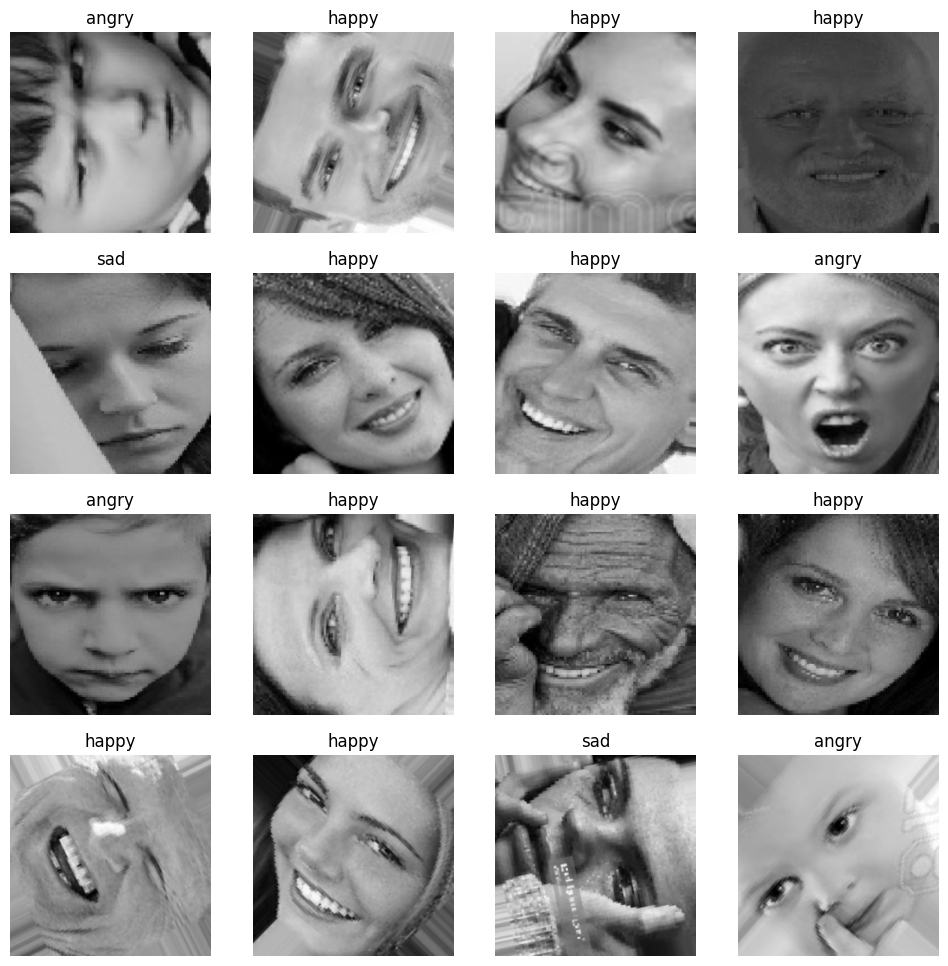

In [11]:
plt.figure(figsize = (12,12))

for im, label in train_dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(im[i]/255.)
    plt.title(CLASSNAME[tf.argmax(label[i], axis=0).numpy()])
    plt.axis("off")

#Data Augmentation

In [12]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.02501),),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1)
])



In [13]:
def augment_layer(image , label):
  return augment_layers(image, training=True), label

#CutMix

In [14]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [15]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [16]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))


In [17]:
training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

#Dataset Prepration

In [18]:
training_dataset = (train_dataset
                    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))

In [19]:
validation_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE))

In [20]:
resize_rescale_layer = tf.keras.Sequential([
  Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
  Rescaling(1./255)
])

#Model

In [21]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None,None, 3)),
    resize_rescale_layer,

    Conv2D(filters=CONFIGURATION['N_FILTERS'], kernel_size=CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'],
           activation='relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPooling2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']),
    Dropout(rate=CONFIGURATION['DROP_RATE']),

    Conv2D(filters=CONFIGURATION['N_FILTERS']*2+4, kernel_size=CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'],
           activation='relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPooling2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),

    Flatten(),

    Dense(CONFIGURATION['N_DENSE_1'], activation='relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION['DROP_RATE']),

    Dense(CONFIGURATION['N_DENSE_2'], activation='relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax'),
])
lenet_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 253, 253, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 253, 253, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 251, 251, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 251, 251, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 125, 125, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 250000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │      25,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,002,719 (95.38 MB)

 Trainable params: 25,002,455 (95.38 MB)

 Non-trainable params: 264 (1.03 KB)

In [22]:


# y_true = tf.constant([[0, 1, 0], [0, 0, 1]], dtype=tf.float32)
# y_pred = tf.constant([[1, 0, 0], [1, 0, 0]], dtype=tf.float32)


# cce = tf.keras.losses.CategoricalCrossentropy()

# loss = cce(y_true, y_pred).numpy()
# print(loss)


In [23]:
loss_function = CategoricalCrossentropy()

In [24]:
metrics = [CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [25]:
lenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics
)

In [26]:
history = lenet_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=CONFIGURATION['N_EPOCHS']
)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 88s 336ms/step - accuracy: 0.4853 - loss: 1.1381 - top_k_accuracy: 0.7664 - val_accuracy: 0.4311 - val_loss: 1.0866 - val_top_k_accuracy: 0.7752
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 64s 300ms/step - accuracy: 0.6164 - loss: 0.8585 - top_k_accuracy: 0.8492 - val_accuracy: 0.5075 - val_loss: 0.9966 - val_top_k_accuracy: 0.8126
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 83s 303ms/step - accuracy: 0.6614 - loss: 0.7614 - top_k_accuracy: 0.8875 - val_accuracy: 0.5786 - val_loss: 0.9596 - val_top_k_accuracy: 0.8354
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 63s 295ms/step - accuracy: 0.7034 - loss: 0.7023 - top_k_accuracy: 0.8981 - val_accuracy: 0.6760 - val_loss: 0.7526 - val_top_k_accuracy: 0.8889
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 64s 299ms/step - accuracy: 0.7306 - loss: 0.6487 - top_k_accuracy: 0.9163 - val_accuracy: 0.5500 - val_loss: 1.1891 - val_top_k_accuracy: 0.7871
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 67s 311ms/step - accuracy: 0.7377 -

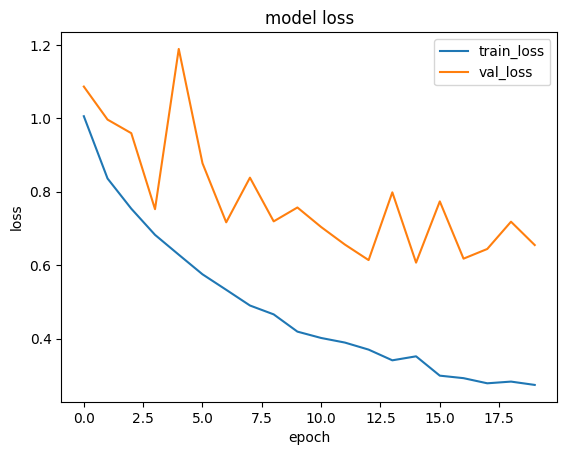

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

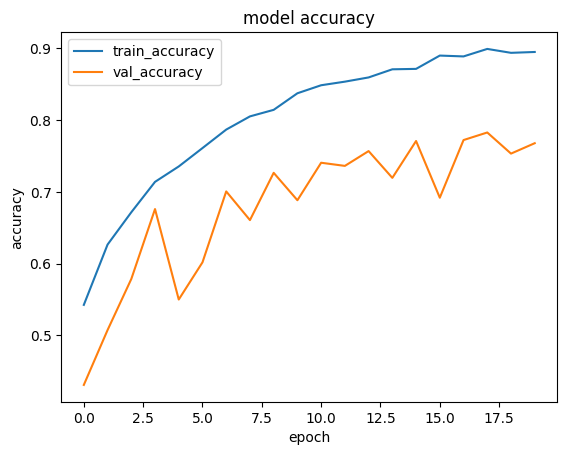

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [29]:
lenet_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7485 - loss: 0.6959 - top_k_accuracy: 0.9238


[0.6549167633056641, 0.767778754234314, 0.9271290898323059]

In [30]:
testImage = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/241429.jpg_brightness_1.jpg")
im = tf.constant(testImage)
im = tf.expand_dims(im, axis=0)
print(CLASSNAME[tf.argmax(lenet_model(im),axis=-1).numpy()[0]])

angry


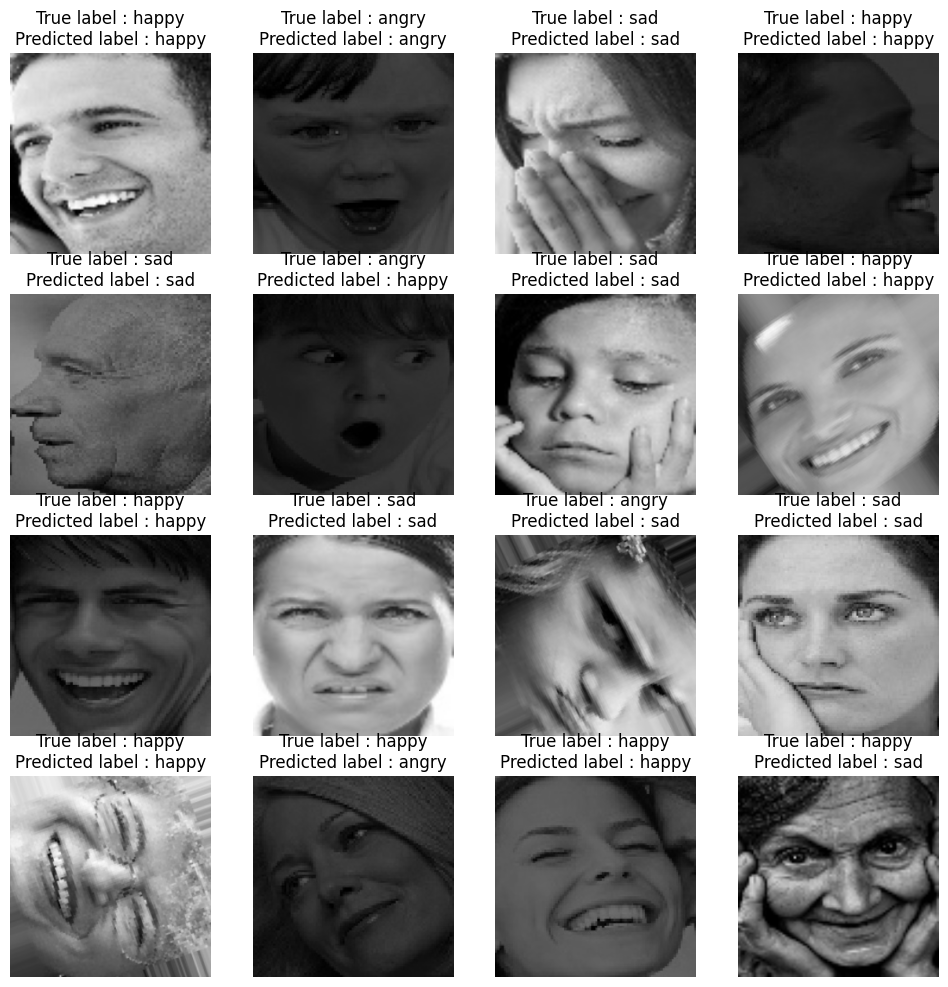

In [37]:
plt.figure(figsize = (12,12))

for im, label in validation_dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(im[i]/255.)
    plt.title("True label : " + CLASSNAME[tf.argmax(label[i], axis=0).numpy()] + "\nPredicted label : " + CLASSNAME[tf.argmax(lenet_model(tf.expand_dims(im[i], axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

In [32]:
12/16

0.75

# Confusion Matrix

In [33]:
Predicted = []
labels = []

for image, label in validation_dataset:
  Predicted.append(lenet_model(image))
  labels.append(label.numpy())

In [34]:
print(np.argmax(labels[:-1], axis=-1).flatten())
print(np.argmax(Predicted[:-1], axis=-1).flatten())

[2 1 2 ... 0 1 0]
[1 1 1 ... 0 0 0]


In [35]:
pred = np.concatenate([np.argmax(Predicted[:-1], axis=-1).flatten(), np.argmax(Predicted[:-1], axis=-1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(),np.argmax(labels[:-1], axis=-1).flatten()])

[[ 710  160  160]
 [ 110 1736  160]
 [ 174  290 1044]]


Text(70.72222222222221, 0.5, 'Actual')

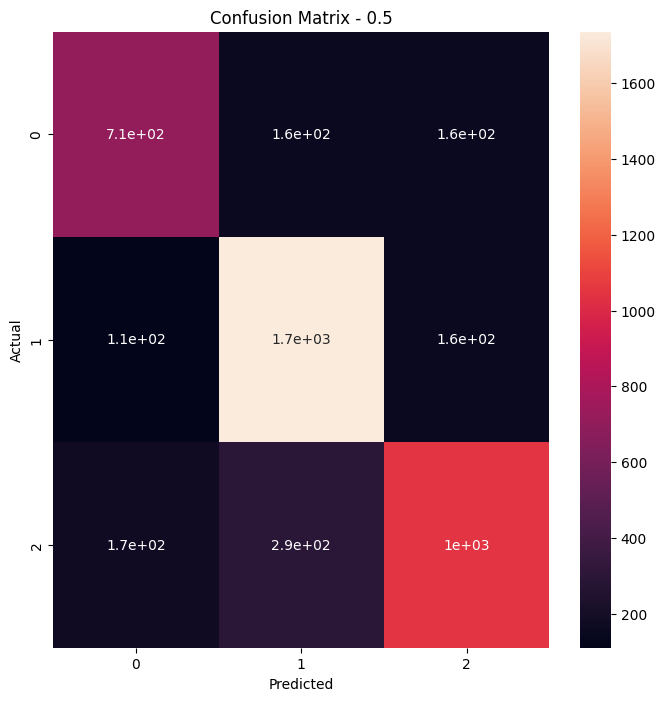

In [36]:
threshhold = 0.5
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize = (8,8))
sns.heatmap(cm , annot=True)
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - {}".format(threshhold))
plt.xlabel("Predicted")
plt.ylabel("Actual")